In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional
from torchvision import datasets, transforms

from foolbox.models import PyTorchModel
from foolbox.criteria import Misclassification
from foolbox.attacks import LocalSearchAttack, BoundaryAttack

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# model definition (example from pytorch/examples/mnist on github)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = functional.relu(functional.max_pool2d(self.conv1(x), 2))
        x = functional.relu(functional.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = functional.relu(self.fc1(x))
        x = functional.dropout(x, training=self.training)
        x = self.fc2(x)
        return functional.log_softmax(x, dim=1)

In [4]:
# initialize/load target network
target = Net()
target.load_state_dict(torch.load('lenet_mnist_model.pth', map_location='cpu'))  # load pre-learned parameters
target.eval()  # put model into evaluation mode

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [5]:
# create foolbox model from target network
fb_model = PyTorchModel(target,
                        bounds=(0,255),  # range of pixel values
                        num_classes=10   # digits 0 to 9
                       )

# set criterion for an adversarial as image with min perturbation causing misclassification
criterion = Misclassification()

# define type of attack (black-box, decision-based)
attack = BoundaryAttack(model=fb_model, criterion=criterion)

In [11]:
# load and format data
train_data = datasets.MNIST(root='D:/', train=True, transform=None, target_transform=None, download=True)

# make sure data has right dimensions for foolbox library, is np.array, and is float
x_train = [(np.array(x[0]).reshape(1, 28, 28)).astype('float32') for x in train_data]
y_train = [np.int(x[1]) for x in train_data]

run with verbose=True to see details
Step 0: 1.88779e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 100: 1.50720e-01, stepsizes = 1.5e-02/4.4e-03: d. reduced by 0.89% (1.3487e-03) (took 0.00000 seconds)


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 200: 6.12607e-02, stepsizes = 3.4e-02/4.4e-03: d. reduced by 0.89% (5.4819e-04) (took 0.01562 seconds)
Step 300: 2.67525e-02, stepsizes = 5.1e-02/4.4e-03: d. reduced by 0.89% (2.3940e-04) (took 0.01565 seconds)
Step 400: 1.38375e-02, stepsizes = 5.1e-02/3.0e-03: d. reduced by 0.89% (1.2383e-04) (took 0.00000 seconds)
Step 500: 9.24261e-03, stepsizes = 3.4e-02/2.0e-03:  (took 0.01562 seconds)
Step 600: 7.32948e-03, stepsizes = 3.4e-02/8.8e-04: d. reduced by 0.18% (1.2886e-05) (took 0.01562 seconds)
Step 700: 5.86366e-03, stepsizes = 3.4e-02/1.3e-03:  (took 0.01562 seconds)
Step 800: 5.20346e-03, stepsizes = 2.3e-02/5.9e-04: d. reduced by 0.12% (6.0962e-06) (took 0.01562 seconds)
Step 900: 4.69119e-03, stepsizes = 2.3e-02/5.9e-04: d. reduced by 0.12% (5.4962e-06) (took 0.01562 seconds)
Step 1000: 4.43828e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 1100: 4.26620e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.2203e-06) (took 0.01562 seconds)
Step 1200: 4.1

Step 4252: 3.67821e-03, stepsizes = 2.7e-10/5.3e-11: 
Step 4253: 3.67821e-03, stepsizes = 2.7e-10/5.3e-11: 
Step 4254: 3.67821e-03, stepsizes = 2.7e-10/5.3e-11: 
Step 4255: 3.67821e-03, stepsizes = 2.7e-10/5.3e-11: 
Step 4256: 3.67821e-03, stepsizes = 1.8e-10/3.5e-11: 
Step 4257: 3.67821e-03, stepsizes = 1.8e-10/3.5e-11: 
Step 4258: 3.67821e-03, stepsizes = 1.8e-10/3.5e-11: 
Step 4259: 3.67821e-03, stepsizes = 1.8e-10/3.5e-11: 
Step 4260: 3.67821e-03, stepsizes = 1.2e-10/2.4e-11: 
Step 4261: 3.67821e-03, stepsizes = 1.2e-10/2.4e-11: 
Step 4262: 3.67821e-03, stepsizes = 1.2e-10/2.4e-11: 
Step 4263: 3.67821e-03, stepsizes = 1.2e-10/2.4e-11: 
Step 4264: 3.67821e-03, stepsizes = 7.9e-11/1.6e-11: 
Step 4265: 3.67821e-03, stepsizes = 7.9e-11/1.6e-11: 
Step 4266: 3.67821e-03, stepsizes = 7.9e-11/1.6e-11: 
Step 4267: 3.67821e-03, stepsizes = 7.9e-11/1.6e-11: 
Step 4268: 3.67821e-03, stepsizes = 5.3e-11/1.0e-11: 
Step 4269: 3.67821e-03, stepsizes = 5.3e-11/1.0e-11: 
Step 4270: 3.67821e-03, step

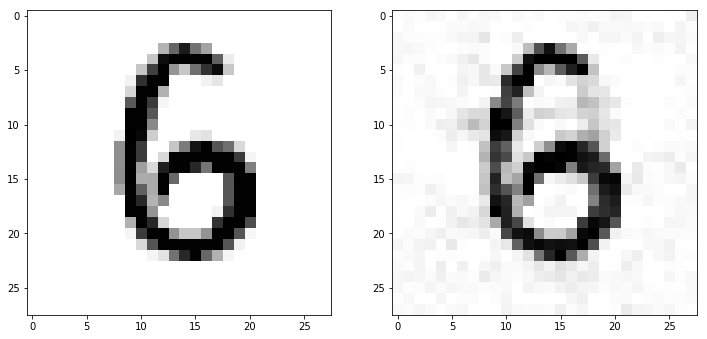

Original prediction:  6
Adversary prediction:  8


In [35]:
i=4934

# generate adversarial image
x_adv = attack(
    input_or_adv=x_train[i],  # original image
    label = y_train[i],       # original label
    unpack = True,            # return adversarial image
    iterations = 6000,        # max iterations of algo
    log_every_n_steps = 100,  # print every 100 iters
    threaded_rnd = True,      # multithread random num gen
    threaded_gen = True       # multithread point generation
)

# display results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(x_train[i].reshape(28,28), cmap=cm.binary)
ax2.imshow(np.array(x_adv).reshape(28,28), cmap=cm.binary)
plt.show()

print("Original prediction:  %d" % fb_model.predictions(x_train[i]).argmax())
print("Adversary prediction:  %d" % fb_model.predictions(x_adv).argmax())